In [1]:
from __future__ import annotations
from pathlib import Path

import re
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import xlsxwriter
from openpyxl import Workbook
from statsmodels.stats.proportion import proportion_confint
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, shapiro, mannwhitneyu
from sklearn.metrics import roc_auc_score

In [2]:
# 1. Chargement et suppression de la ligne description
df = pd.read_excel('../data/REACT-HF_v2_06102025.xlsx')
df_raw = df.iloc[1:].copy()

In [3]:
# 2. Suppression des colonnes sans données
drop_cols = [
    'MODE_DE_VIE'
]
df_raw = df_raw.drop(columns=drop_cols)

# 3. Renommage de quelques colonnes
df_raw = df_raw.rename(columns={
    'PRESENCE_ISGLT2_FEVG>50%': 'PRESENCE_ISGLT2_FEVG_sup50',
    '>/=3_FANTASTIQUES_FEVG<50%': 'FANTASTIQUES_3_FEVG_inf50',
    'ANEMIE_HB<10g/l':'ANEMIE_HB_inf10_gl',
    'PRESENCE_BB-':            'PRESENCE_BB',
    'PRESENCE_IECi/ARA2':    'PRESENCE_IECi_ARA2',
    'NT-PRO_BNP_SORTIE': 'NT_PRO_BNP_SORTIE',
    'ATCD_FA/FLUTTER': 'ATCD_FA_FLUTTER',
    'PM/DAI': 'PM_DAI'
})

In [4]:
# 3. Changegment des modalités
cols_to_recode = ['MODE_ADMISSION', 'MODE_READMISSION_IC']

for col in cols_to_recode:
    # Convertir en string explicite (sécurisé même si c'est déjà string)
    df_raw[col] = df_raw[col].astype(str)

    # Fusionner les modalités 0 et 2, garder 1
    df_raw[col] = df_raw[col].map({
        '0': '0',
        '2': '0',
        '1': '1'
    })


In [5]:
# 4. Définition des listes de variables par type
char_cols    = ['NUMERO_PATIENT']

integer_cols = ['AGE','DMS','SCORE_CHARLSON','NT_PRO_BNP_SORTIE','FERRITINE','DOSAGE_SORTIE_DIURETIC', 'DMS_REHOSPITALISATION_IC',
                'NBRE_REHOSPITALISATION_IC_12MOIS']

double_cols  = ['ADL','IMC','ALBUMINE']

percent_cols = ['HbA1c','CST']

bool_vars    = [
    'SEXE','OBESITE','DENUTRITION_CONFIRMEE','CHARLSON>6','SYNDROME_DEPRESSIF','TROUBLES_COGNITIFS_SEVERES','ATCD_CANCER','CANCER_ACTIF',
    'ATCD_BPCO','ATCD_HTA','ATCD_DYSLIPIDEMIE','ATCD_DIABETE','ATCD_AVC','ATCD_AOMI','ATCD_FA_FLUTTER',
    'ATCD_AMYLOSE','PM_DAI','RAC_AU_MOINS_MODEREE','IM_AU_MOINS_MODEREE','IT_AU_MOINS_MODEREE','ALBUMINE<35',"DFG<45","NTproBNP>5000",
    'CARENCE_MARTIALE_VRAIE','CARENCE_MARTIALE_FONCTIONNELLE','ANEMIE_HB_inf10_gl','CARENCE_VITAMINE_B9',
    'CARENCE_VITAMINE_B12','CARENCE_VITAMINE_D','PRESENCE_IECi_ARA2','PRESENCE_ACEi','PRESENCE_BB',
    'PRESENCE_MRA','PRESENCE_SORTIE_ISGLT2','PRESENCE_SORTIE_DIURETIC','PRESENCE_SORTIE_ANTICOAGULANT',
    'PRESENCE_SORTIE_AAP','PRESENCE_ISGLT2_FEVG_sup50','FANTASTIQUES_3_FEVG_inf50','OUTCOME_REHOSPITALISATION_12MOIS'
]
ordinal_mappings = {
    'DENUTRITION': {'0':'Risque dénutrition','1':'Dénutrition modérée','2':'Dénutrition sévère','NC':'Inconnu'},
    'ATCD_CARDIOPATHIE_ISCHEMIQUE': {'0':'NON','1':'Traitement médical','2':'Angioplastie stent','3':'Pontage'},
    'FEVG_CLASSE': {'0':'Altérée (</=40%)','1':'Moyennement altérée (41-49%)','2':'Préservée (>/=50%)'},
    'STADE_IRC_DFG_SORTIE': {'1':'DFG>90 ml/min','2':'DFG=60-89 ml/min','3A':'45-59 ml/min','3B':'30-44 ml/min','4':'15-29 ml/min','5':'<14 ml/min'},
    'TYPE_DIURETIC': {'0':'FUROSEMIDE','1':'BUMETAMIDE'},
    'TYPE_SUIVI_SATELIA': {'0':'Patient','1':'Aidant', '2':'IDEL','3':'Satelia'},
    'MODE_ADMISSION' : {'0':'SAU & transfert MCO', '1':'admission directe'},
    'MODE_READMISSION_IC' : {'0':'SAU & transfert MCO', '1':'admission directe'}
}
rehosp_cols = [
    'REHOSPITALISATION_IC_1MOIS','REHOSPITALISATION_IC_3MOIS',
    'REHOSPITALISATION_IC_6MOIS','REHOSPITALISATION_IC_12MOIS'
]

In [6]:
# 5. Application des transformations
df_clean = df_raw.copy()

# → Caractères
for col in char_cols:
    df_clean[col] = df_clean[col].astype(str)

# → Doubles (correction : on force en str avant le .str.strip())
for col in double_cols:
    df_clean[col] = pd.to_numeric(
        df_clean[col].astype(str).str.strip().replace('NC', pd.NA),
        errors='coerce'
    )

# → Entiers (extraction de chiffres puis Int64 pour garder les NA)
for col in integer_cols:
    df_clean[col] = df_clean[col].astype(str).str.extract(r'(\d+)', expand=False)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').astype('Int64')

# → Pourcentages
for col in percent_cols:
    df_clean[col] = df_clean[col].astype(str).str.replace('%','').str.strip().replace('NC', pd.NA)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# → Booléens en catégories “No”/“Yes”
bool_map = {'1':True,'0':False,1:True,0:False,True:True,False:False}
for col in bool_vars:
    df_clean[col] = df_clean[col].map(bool_map)
    df_clean[col] = df_clean[col].map({False:'No',True:'Yes'}).astype('category')

# → Réhospitalisations
for col in rehosp_cols:
    # 1) on force en numérique (les NC, '', etc. deviennent NaN)
    num = pd.to_numeric(df_clean[col], errors='coerce')
    # 2) on mappe 1→Yes, 0→No
    df_clean[col] = num.map({1:'Yes', 0:'No'}).astype('category')

# → Variables ordinales
for col, mapping in ordinal_mappings.items():
    cat_type = CategoricalDtype(categories=list(mapping.values()), ordered=True)
    df_clean[col] = df_clean[col].astype(str).map(mapping).astype(cat_type)


In [7]:
# 6. Vérification rapide
df_clean.head()

,NUMERO_PATIENT,DDN,DATE_ADMISSION,NB_MOIS_SUIVI,AGE,AGE>85,SEXE,MODE_ADMISSION,DMS,ADL,...,PRESENCE_SORTIE_AAP,TYPE_SUIVI_SATELIA,OUTCOME_REHOSPITALISATION_12MOIS,REHOSPITALISATION_IC_1MOIS,REHOSPITALISATION_IC_3MOIS,REHOSPITALISATION_IC_6MOIS,REHOSPITALISATION_IC_12MOIS,DMS_REHOSPITALISATION_IC,MODE_READMISSION_IC,NBRE_REHOSPITALISATION_IC_12MOIS
1,1.0,1941-01-01,2024-07-16,13.0,83,0,No,SAU & transfert MCO,5,4.5,...,No,Satelia,Yes,No,No,No,No,<NA>,NaN,0
2,2.0,1943-12-11,2024-03-22,13.0,80,0,No,SAU & transfert MCO,7,5.5,...,No,Satelia,Yes,No,No,No,Yes,<NA>,NaN,1
3,3.0,1941-10-13,2024-06-26,15.0,82,0,No,SAU & transfert MCO,6,5.5,...,No,Patient,Yes,No,No,No,Yes,8,SAU & transfert MCO,1
4,4.0,1929-09-27,2023-12-05,21.0,94,1,Yes,SAU & transfert MCO,6,5.5,...,Yes,Aidant,No,No,No,No,No,<NA>,NaN,0
5,5.0,1944-01-25,2024-05-29,16.0,80,0,No,SAU & transfert MCO,6,6.0,...,No,Satelia,Yes,No,No,No,Yes,8,SAU & transfert MCO,1


In [8]:
print(df_clean.dtypes)

NUMERO_PATIENT                              object
DDN                                 datetime64[ns]
DATE_ADMISSION                      datetime64[ns]
NB_MOIS_SUIVI                              float64
AGE                                          Int64
                                         ...      
REHOSPITALISATION_IC_6MOIS                category
REHOSPITALISATION_IC_12MOIS               category
DMS_REHOSPITALISATION_IC                     Int64
MODE_READMISSION_IC                       category
NBRE_REHOSPITALISATION_IC_12MOIS             Int64
Length: 71, dtype: object


In [9]:
# Fonction pour calculer la proportion de NA et ne conserver que les colonnes à NA > 0
def na_props(df, cols):
    # isna().mean() donne la proportion de NA par colonne
    props = df[cols].isna().mean()
    return props[props > 0]

# Appliquer à chaque groupe de colonnes
integer_na   = na_props(df_clean, integer_cols)
double_na    = na_props(df_clean, double_cols)
percent_na   = na_props(df_clean, percent_cols)
bool_na      = na_props(df_clean, bool_vars)
rehosp_na    = na_props(df_clean, rehosp_cols)
ordinal_na   = na_props(df_clean, list(ordinal_mappings.keys()))

# Afficher le résultat
missing_summary = {
    'integer'          : integer_na,
    'double'           : double_na,
    'percent'          : percent_na,
    'boolean'          : bool_na,
    'rehospitalisation': rehosp_na,
    'ordinal'          : ordinal_na
}

for group, series in missing_summary.items():
    print(f"\n– {group} cols with NA > 0:")
    print(series)



– integer cols with NA > 0:
NT_PRO_BNP_SORTIE                   0.019608
FERRITINE                           0.054902
DOSAGE_SORTIE_DIURETIC              0.074510
DMS_REHOSPITALISATION_IC            0.737255
NBRE_REHOSPITALISATION_IC_12MOIS    0.023529
dtype: float64

– double cols with NA > 0:
ALBUMINE    0.007843
dtype: float64

– percent cols with NA > 0:
HbA1c    0.207843
CST      0.066667
dtype: float64

– boolean cols with NA > 0:
DENUTRITION_CONFIRMEE             0.003922
ATCD_HTA                          0.003922
RAC_AU_MOINS_MODEREE              0.015686
IM_AU_MOINS_MODEREE               0.015686
IT_AU_MOINS_MODEREE               0.019608
ALBUMINE<35                       0.007843
NTproBNP>5000                     0.019608
CARENCE_MARTIALE_VRAIE            0.054902
CARENCE_MARTIALE_FONCTIONNELLE    0.054902
CARENCE_VITAMINE_B9               0.054902
CARENCE_VITAMINE_B12              0.054902
CARENCE_VITAMINE_D                0.039216
PRESENCE_ISGLT2_FEVG_sup50        0.388235

In [10]:
# Variables ordinales (noms uniquement)
ordinal_vars = [
    'DENUTRITION', 'ATCD_CARDIOPATHIE_ISCHEMIQUE', 'FEVG_CLASSE',
    'STADE_IRC_DFG_SORTIE', 'TYPE_DIURETIC', 'TYPE_SUIVI_SATELIA'
]

# Variables "spéciales"
special_vars = [
    'PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50',
    'MODE_ADMISSION', 'MODE_READMISSION_IC'
]

# On retire special_vars de la liste des booléens
bool_wo_special = [col for col in bool_vars if col not in special_vars]

# Variables continues
cont_vars = double_cols + integer_cols + percent_cols

# Variables catégorielles (booléennes non spéciales + ordinales + spéciales)
cat_vars_initial = bool_wo_special + ordinal_vars + special_vars

# 1. Vos vraies binaires (sans les ordinales)
cat_vars = [col for col in cat_vars_initial if col not in ordinal_vars]

all_vars = cont_vars + cat_vars + ordinal_vars

horizons = rehosp_cols[:4]

# Affichage des listes
print("cont_vars:", cont_vars)
print("\ncat_vars_all:", cat_vars_initial )
print("\nhorizons:", horizons)

cont_vars: ['ADL', 'IMC', 'ALBUMINE', 'AGE', 'DMS', 'SCORE_CHARLSON', 'NT_PRO_BNP_SORTIE', 'FERRITINE', 'DOSAGE_SORTIE_DIURETIC', 'DMS_REHOSPITALISATION_IC', 'NBRE_REHOSPITALISATION_IC_12MOIS', 'HbA1c', 'CST']

cat_vars_all: ['SEXE', 'OBESITE', 'DENUTRITION_CONFIRMEE', 'CHARLSON>6', 'SYNDROME_DEPRESSIF', 'TROUBLES_COGNITIFS_SEVERES', 'ATCD_CANCER', 'CANCER_ACTIF', 'ATCD_BPCO', 'ATCD_HTA', 'ATCD_DYSLIPIDEMIE', 'ATCD_DIABETE', 'ATCD_AVC', 'ATCD_AOMI', 'ATCD_FA_FLUTTER', 'ATCD_AMYLOSE', 'PM_DAI', 'RAC_AU_MOINS_MODEREE', 'IM_AU_MOINS_MODEREE', 'IT_AU_MOINS_MODEREE', 'ALBUMINE<35', 'DFG<45', 'NTproBNP>5000', 'CARENCE_MARTIALE_VRAIE', 'CARENCE_MARTIALE_FONCTIONNELLE', 'ANEMIE_HB_inf10_gl', 'CARENCE_VITAMINE_B9', 'CARENCE_VITAMINE_B12', 'CARENCE_VITAMINE_D', 'PRESENCE_IECi_ARA2', 'PRESENCE_ACEi', 'PRESENCE_BB', 'PRESENCE_MRA', 'PRESENCE_SORTIE_ISGLT2', 'PRESENCE_SORTIE_DIURETIC', 'PRESENCE_SORTIE_ANTICOAGULANT', 'PRESENCE_SORTIE_AAP', 'OUTCOME_REHOSPITALISATION_12MOIS', 'DENUTRITION', 'ATCD_C

In [11]:
print(cat_vars)

['SEXE', 'OBESITE', 'DENUTRITION_CONFIRMEE', 'CHARLSON>6', 'SYNDROME_DEPRESSIF', 'TROUBLES_COGNITIFS_SEVERES', 'ATCD_CANCER', 'CANCER_ACTIF', 'ATCD_BPCO', 'ATCD_HTA', 'ATCD_DYSLIPIDEMIE', 'ATCD_DIABETE', 'ATCD_AVC', 'ATCD_AOMI', 'ATCD_FA_FLUTTER', 'ATCD_AMYLOSE', 'PM_DAI', 'RAC_AU_MOINS_MODEREE', 'IM_AU_MOINS_MODEREE', 'IT_AU_MOINS_MODEREE', 'ALBUMINE<35', 'DFG<45', 'NTproBNP>5000', 'CARENCE_MARTIALE_VRAIE', 'CARENCE_MARTIALE_FONCTIONNELLE', 'ANEMIE_HB_inf10_gl', 'CARENCE_VITAMINE_B9', 'CARENCE_VITAMINE_B12', 'CARENCE_VITAMINE_D', 'PRESENCE_IECi_ARA2', 'PRESENCE_ACEi', 'PRESENCE_BB', 'PRESENCE_MRA', 'PRESENCE_SORTIE_ISGLT2', 'PRESENCE_SORTIE_DIURETIC', 'PRESENCE_SORTIE_ANTICOAGULANT', 'PRESENCE_SORTIE_AAP', 'OUTCOME_REHOSPITALISATION_12MOIS', 'PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50', 'MODE_ADMISSION', 'MODE_READMISSION_IC']


In [12]:
print(ordinal_vars)

['DENUTRITION', 'ATCD_CARDIOPATHIE_ISCHEMIQUE', 'FEVG_CLASSE', 'STADE_IRC_DFG_SORTIE', 'TYPE_DIURETIC', 'TYPE_SUIVI_SATELIA']


In [13]:
for h in horizons:
    print(f"Horizon {h!r} → modalities:", df_clean[h].value_counts(dropna=False).to_dict())


Horizon 'REHOSPITALISATION_IC_1MOIS' → modalities: {'No': 246, 'Yes': 9}
Horizon 'REHOSPITALISATION_IC_3MOIS' → modalities: {'No': 230, 'Yes': 25}
Horizon 'REHOSPITALISATION_IC_6MOIS' → modalities: {'No': 214, 'Yes': 41}
Horizon 'REHOSPITALISATION_IC_12MOIS' → modalities: {'No': 192, 'Yes': 63}


In [14]:
confounders  = ["AGE", "SEXE", "ATCD_HTA", "SCORE_CHARLSON", 
              "IM_AU_MOINS_MODEREE", "CARENCE_MARTIALE_VRAIE"]

special_bools = ['PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50']

# Nouvelle Etude

In [15]:
"""
Univariate & Multivariate Readmission Analysis
--------------------------------------------------
Améliorations par rapport à la v1 :
• Suppression de la logique « special_vars »
• Tests continus : choix Welch vs Mann–Whitney
• IC 95 % : Student t / bootstrap
• Colonne `test_used` + `add_stat_label` pour suffixes Mean (SD) ou Median [IQR]
• Ajustement multivarié : GLM logit, Wald vs LRT
• Diagnostics : AUC/ROC, VIF, Box–Tidwell
• Export Excel : 1 onglet / horizon, titres figés, p<0.05 en rouge

Entrées attendues :
    df_clean : DataFrame nettoyé
    horizons, cont_vars, ordinal_vars, bool_vars, confounders
"""

# 1) Tests & IC helpers
# ----------------------
def _is_normal(x: pd.Series, alpha: float = 0.05) -> bool:
    x = pd.to_numeric(x, errors="coerce").dropna().astype(float)
    if len(x) < 3 or x.nunique() <= 1 or np.isclose(x.var(ddof=0), 0):
        return True
    n = len(x)
    if n < 50:
        p = stats.shapiro(x)[1]
    else:
        p = stats.normaltest(x)[1]
        if n >= 5000 and p < alpha:
            skew, kurt = stats.skew(x), stats.kurtosis(x, fisher=False)
            if abs(skew) < 1 and abs(kurt - 3) < 1:
                p = alpha + 0.01
    return p > alpha


def _welch_ci(x: np.ndarray, alpha: float = 0.05) -> tuple[float, float]:
    m, s, n = x.mean(), x.std(ddof=1), len(x)
    se = s / np.sqrt(n)
    t = stats.t.ppf(1 - alpha / 2, df=n - 1)
    return m - t * se, m + t * se


def _median_ci_bootstrap(x: np.ndarray, alpha: float = 0.05, n_boot: int = 2000, seed: int | None = None) -> tuple[float, float]:
    arr = x if isinstance(x, np.ndarray) else np.asarray(x.dropna(), float)
    if len(arr) == 0:
        return np.nan, np.nan
    rng = np.random.default_rng(seed)
    meds = np.median(rng.choice(arr, size=(n_boot, len(arr)), replace=True), axis=1)
    lo, hi = np.percentile(meds, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return lo, hi

# 2) Univariate summary per horizon
# ----------------------------------
def univariate_summary_horizon(
    df: pd.DataFrame,
    horizon_col: str,
    cont_vars: List[str],
    ordinal_vars: List[str],
    bool_vars: List[str],
    alpha: float = 0.05,
    decimals: int = 2,
) -> pd.DataFrame:
    mask_yes = df[horizon_col] == "Yes"
    mask_no  = df[horizon_col] == "No"
    n_yes, n_no = mask_yes.sum(), mask_no.sum()
    N = len(df)

    rows: List[Dict[str, str]] = [{
        "Variable": "Total", "Level": "",
        "Missing": f"{df[horizon_col].isna().sum()} ({df[horizon_col].isna().mean()*100:.1f}%)",
        "Overall": f"{n_yes + n_no}",
        "Yes":     f"{n_yes} ({n_yes/(n_yes+n_no)*100:.1f}%)",
        "No":      f"{n_no} ({n_no/(n_yes+n_no)*100:.1f}%)",
        "CI_95":   "", "p_value": "", "test_used": ""
    }]

    # Continues
    for var in cont_vars:
        if var not in df: continue
        x_yes = pd.to_numeric(df.loc[mask_yes, var], errors="coerce").dropna()
        x_no  = pd.to_numeric(df.loc[mask_no,  var], errors="coerce").dropna()
        x_all = pd.to_numeric(df[var], errors="coerce").dropna()
        miss = df[var].isna().sum(); miss_str = f"{miss} ({miss/N*100:.1f}%)"
        normal = _is_normal(x_yes) and _is_normal(x_no)
        if normal:
            fmt = lambda s: f"{s.mean():.{decimals}f} ± {s.std(ddof=1):.{decimals}f}"
            p = stats.ttest_ind(x_yes, x_no, equal_var=False).pvalue if len(x_yes)>1 and len(x_no)>1 else np.nan
            lo, hi = _welch_ci(x_yes.to_numpy()) if len(x_yes)>1 else (np.nan, np.nan)
            test = "Welch t-test"
        else:
            fmt = lambda s: f"{s.median():.{decimals}f} [{s.quantile(.25):.{decimals}f}–{s.quantile(.75):.{decimals}f}]"
            p = stats.mannwhitneyu(x_yes, x_no, alternative="two-sided").pvalue if len(x_yes)>0 and len(x_no)>0 else np.nan
            lo, hi = _median_ci_bootstrap(x_yes.to_numpy())
            test = "Mann–Whitney U"
        ci = f"{lo:.{decimals}f}–{hi:.{decimals}f}" if not np.isnan(lo) else ""
        p_str = "" if np.isnan(p) else ("<0.001" if p<0.001 else f"{p:.3f}")
        # suffix label
        label = var
        val = fmt(x_all) if len(x_all)>0 else ""
        if "±" in val:
            label += " Mean (SD)"
        elif "[" in val and "]" in val:
            label += " Median [IQR]"
        rows.append({
            "Variable": label, "Level": "", "Missing": miss_str,
            "Overall": fmt(x_all) if len(x_all)>0 else "",
            "Yes":     fmt(x_yes) if len(x_yes)>0 else "",
            "No":      fmt(x_no)  if len(x_no)>0  else "",
            "CI_95":   ci,
            "p_value": p_str,
            "test_used": test
        })

    # Ordinales
    for var in ordinal_vars:
        if var not in df: continue
        ser = df[var].astype("category")
        if not ser.cat.ordered:
            ser = ser.cat.as_ordered()
        miss = ser.isna().sum(); miss_str = f"{miss} ({miss/N*100:.1f}%)"
        tbl = pd.crosstab(ser, df[horizon_col])
        p_cat = stats.chi2_contingency(tbl)[1] if tbl.size else np.nan
        p_str_cat = "<0.001" if not np.isnan(p_cat) and p_cat<0.001 else (f"{p_cat:.3f}" if not np.isnan(p_cat) else "")
        first=True
        for lvl in ser.cat.categories:
            n_lvl = int((ser==lvl).sum())
            pct_lvl = n_lvl/ser.notna().sum()*100 if ser.notna().sum()>0 else 0
            yes_lvl = int(((ser==lvl)&mask_yes).sum()); pct_yes = yes_lvl/n_yes*100 if n_yes else 0
            no_lvl  = int(((ser==lvl)&mask_no).sum());  pct_no  = no_lvl/n_no*100  if n_no else 0
            lo, hi = (proportion_confint(yes_lvl,n_yes,alpha=alpha,method="wilson") if n_yes else (np.nan,np.nan))
            ci = f"{lo*100:.1f}%–{hi*100:.1f}%" if n_yes else ""
            rows.append({
                "Variable": var, "Level": str(lvl), "Missing": miss_str if first else "",
                "Overall": f"{n_lvl} ({pct_lvl:.1f}%)",
                "Yes":     f"{yes_lvl} ({pct_yes:.1f}%)",
                "No":      f"{no_lvl} ({pct_no:.1f}%)",
                "CI_95":   ci,
                "p_value": p_str_cat if first else "",
                "test_used": "Chi²" if first else ""
            })
            first=False

    # Binaires
    for var in bool_vars:
        if var not in df: continue
        ser = df[var].map({"Yes":True,"No":False}).astype("boolean")
        miss = ser.isna().sum(); miss_str = f"{miss} ({miss/N*100:.1f}%)"
        a = int(((ser)&mask_yes).sum()); b = int(((~ser)&mask_yes).sum())
        c = int(((ser)&mask_no).sum());  d = int(((~ser)&mask_no).sum())
        table = np.array([[a,b],[c,d]])
        if (table<5).any(): pval, test = stats.fisher_exact(table)[1], "Fisher"
        else:               pval, test = stats.chi2_contingency(table)[1], "Chi²"
        p_str = "" if np.isnan(pval) else ("<0.001" if pval<0.001 else f"{pval:.3f}")
        lo, hi = (proportion_confint(a,n_yes,alpha=alpha,method="wilson") if n_yes else (np.nan,np.nan))
        ci = f"{lo*100:.1f}%–{hi*100:.1f}%" if n_yes else ""
        rows.append({
            "Variable": var, "Level": "", "Missing": miss_str,
            "Overall": f"{int(ser.sum())} ({ser.mean()*100:.1f}%)",
            "Yes":     f"{a} ({a/n_yes*100:.1f}%)",
            "No":      f"{c} ({c/n_no*100:.1f}%)",
            "CI_95":   ci,
            "p_value": p_str,
            "test_used": test
        })

    return pd.DataFrame(rows, columns=["Variable","Level","Missing","Overall","Yes","No","CI_95","p_value","test_used"])

# 3) Multivariate adjustment & diagnostics
# ----------------------------------------
def add_multivariate_p(
    summary_df: pd.DataFrame,
    df: pd.DataFrame,
    horizon_col: str,
    confounders: List[str],
    all_vars: List[str],
) -> pd.DataFrame:
    dfh = df[df[horizon_col].isin(["Yes","No"])].copy()
    dfh['y'] = dfh[horizon_col].map({'Yes':1,'No':0})
    p_map: Dict[str, str] = {}
    test_map: Dict[str, str] = {}
    for var in all_vars:
        conf = [c for c in confounders if c!=var and c in dfh]
        dmod = dfh.dropna(subset=[var]+conf).copy()
        if dmod.empty: continue
        X_full = pd.get_dummies(dmod[[var]+conf], drop_first=True)
        X_full = sm.add_constant(X_full).astype(float)
        y = dmod['y']
        try:
            res = sm.GLM(y, X_full, family=sm.families.Binomial()).fit(disp=False)
        except:
            continue
        coeffs = [c for c in X_full.columns if c==var or c.startswith(f"{var}_")]
        if len(coeffs)<=1:
            p, test = res.pvalues.get(coeffs[0], np.nan) if coeffs else np.nan, 'Wald (logit)'
        else:
            X_red = X_full.drop(columns=coeffs)
            res_red = sm.GLM(y, X_red, family=sm.families.Binomial()).fit(disp=False)
            LR, df_diff = 2*(res.llf - res_red.llf), len(coeffs)
            p, test = stats.chi2.sf(LR, df=df_diff), 'LRT (logit)'
        p_map[var], test_map[var] = ('<0.001' if p<0.001 else f"{p:.3f}"), test
    out = summary_df.copy()
    raw = out['Variable'].str.replace(r" Mean \(SD\)$| Median \[IQR\]$", '', regex=True)
    out['p_value_multi'] = raw.map(p_map).fillna('')
    out['test_used_multi'] = raw.map(test_map).fillna('')
    return out

# 4) Table spéciale booléenne (Yes/No)
# ------------------------------------------------

def build_special_bool_table(
    summary_df: pd.DataFrame,
    df: pd.DataFrame,
    horizon_col: str,
    var: str,
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Mini-tableau pour un booléen spécial :
      1) Une ligne par niveau (No, Yes)
      2) Une ligne Total (somme des yes_h et no_h)

    Colonnes : Variable, Level, Missing, Overall, Yes, No,
               CI_95, p_value, test_used, p_value_multi, test_used_multi
    """
    # 1. Récupérer p_value_multi & test_used_multi
    uni_row = summary_df[(summary_df["Variable"] == var) & (summary_df["Level"] == "")]
    p_mv    = uni_row["p_value_multi"].iat[0] if not uni_row.empty else ""
    test_mv = uni_row["test_used_multi"].iat[0]   if not uni_row.empty else ""

    # 2. Sous-jeu où horizon est renseigné
    dfh = df[df[horizon_col].isin(["Yes","No"])].copy()
    mask_h_yes = dfh[horizon_col] == "Yes"
    mask_h_no  = dfh[horizon_col] == "No"

    # 3. Série de la variable spéciale
    ser = dfh[var].map({"Yes": True, "No": False}).astype("boolean")
    n_obs  = ser.notna().sum()
    n_miss = len(dfh) - n_obs

    # 4. Pré-calcul pour chaque niveau
    rows = []
    sum_yes_h = 0
    sum_no_h  = 0

    # IC Wilson pour var==True
    n_yes   = int((ser == True).sum())
    lo, hi  = proportion_confint(n_yes, n_obs, alpha=alpha, method="wilson")
    ci_yes  = f"{lo*100:.1f}%–{hi*100:.1f}%"

    # Test univarié
    cont = pd.crosstab(ser, dfh[horizon_col])
    if cont.shape == (2,2):
        p_uni, test_uni = fisher_exact(cont.values)[1], "Fisher"
    else:
        p_uni, test_uni = chi2_contingency(cont)[1], "Chi²"
    p_uni_str = "<0.001" if p_uni < 0.001 else f"{p_uni:.3f}"

    for level in [False, True]:
        lvl_name = "No" if level is False else "Yes"
        mask_lvl = ser == level
        # effectifs
        yes_h = int((mask_lvl & mask_h_yes).sum())
        no_h  = int((mask_lvl & mask_h_no).sum())
        sum_yes_h += yes_h
        sum_no_h  += no_h
        overall_count = mask_lvl.sum()
        pct_overall   = overall_count / n_obs * 100 if n_obs else 0

        rows.append({
            "Variable":        var,
            "Level":           lvl_name,
            "Missing":         f"{n_miss} ({n_miss/len(dfh)*100:.1f}%)",
            "Overall":         f"{overall_count} ({pct_overall:.1f}%)",
            "Yes":             f"{yes_h} ({yes_h/sum_yes_h*100 if sum_yes_h else 0:.1f}%)",
            "No":              f"{no_h} ({no_h/sum_no_h*100  if sum_no_h  else 0:.1f}%)",
            "CI_95":           ci_yes    if level is True else "",
            "p_value":         p_uni_str if level is False else "",
            "test_used":       test_uni  if level is False else "",
            "p_value_multi":   ""        if level is False else "",
            "test_used_multi": ""        if level is False else ""
        })

    # 5. Construire la ligne Total (en sommant)
    rows.insert(0, {
        "Variable":        var,
        "Level":           "",
        "Missing":         f"{n_miss} ({n_miss/len(dfh)*100:.1f}%)",
        "Overall":         f"{n_obs} ({n_obs/len(dfh)*100:.1f}%)",
        "Yes":             f"{sum_yes_h} ({sum_yes_h/n_obs*100:.1f}%)",
        "No":              f"{sum_no_h} ({sum_no_h/n_obs*100:.1f}%)",
        "CI_95":           "",
        "p_value":         "",
        "test_used":       "",
        "p_value_multi":   p_mv,
        "test_used_multi": test_mv
    })

    return pd.DataFrame(rows, columns=[
        "Variable","Level","Missing","Overall","Yes","No",
        "CI_95","p_value","test_used","p_value_multi","test_used_multi"
    ])

# 4) Création d'un export excel avec tous les tableaux
# ------------------------------------------------

def excel_export(
    tables: Dict[str, pd.DataFrame],
    horizons: List[str],
    special_bools: List[str],
    output_path: Path
):
    output_path = Path(output_path)
    output_path.parent.mkdir(exist_ok=True, parents=True)
    with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
        wb = writer.book
        fmt_red = wb.add_format({"font_color": "red", "bold": True})

        for h in horizons:
            sheet = h.split("_")[-1][:31]
            row = 0

            # 1) global
            df_global = tables[f"Global_{h}"]
            df_global.to_excel(writer, sheet_name=sheet, startrow=row, index=False)
            ws = writer.sheets[sheet]
            ws.freeze_panes(1, 1)
            for col in ("p_value","p_value_multi"):
                if col in df_global:
                    ci = df_global.columns.get_loc(col)
                    ws.conditional_format(row+1, ci, row+1+len(df_global), ci,
                                          {"type":"cell","criteria":"<","value":0.05,"format":fmt_red})

            # 2) mini‐tables spéciales, avec le même préfixe « Spec_ » que dans run_full_analysis
            row += len(df_global) + 2
            for var in special_bools:
                key = f"Spec_{var}_{h}"           # <— ici on récupère la bonne clé
                if key not in tables:
                    raise KeyError(f"Clé manquante dans tables: {key}")
                ws.write(row, 0, f"Spéciale : {var}", wb.add_format({"italic": True}))
                row += 1

                df_spec = tables[key]
                df_spec.to_excel(writer, sheet_name=sheet, startrow=row, index=False)
                for col in ("p_value","p_value_multi"):
                    if col in df_spec:
                        ci = df_spec.columns.get_loc(col)
                        ws.conditional_format(row+1, ci, row+1+len(df_spec), ci,
                                              {"type":"cell","criteria":"<","value":0.05,"format":fmt_red})
                row += len(df_spec) + 2

    print(f"✅ Export Excel : {output_path.resolve()}")

# 6) Full pipeline & diagnostics + tables spéciales
# -------------------------------------------------

def run_full_analysis(
    df: pd.DataFrame,
    horizons: List[str],
    cont_vars: List[str],
    ordinal_vars: List[str],
    bool_vars: List[str],
    confounders: List[str],
    output_path: Path | str = 'Etude_Readmission_v3.xlsx',
    special_bools: List[str] = ['PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50'],
) -> Dict[str, pd.DataFrame]:
    """
    Pour chaque horizon :
      - univarié + multivarié
      - diagnostics (AUC/ROC, VIF, Box–Tidwell)
      - tableaux spéciaux pour les booléens listés
      - export Excel final
    """
    all_vars = cont_vars + ordinal_vars + bool_vars
    tables: Dict[str, pd.DataFrame] = {}

    for h in horizons:
        # 1) Table global
        uni     = univariate_summary_horizon(df, h, cont_vars, ordinal_vars, bool_vars)
        uni_adj = add_multivariate_p(uni, df, h, confounders, all_vars)
        tables[f'Global_{h}'] = uni_adj

        # 2) Diagnostics dataset
        endog = df[h].map({'Yes':1,'No':0})
        exog  = pd.get_dummies(df[all_vars+confounders], drop_first=True)
        exog  = sm.add_constant(exog, has_constant='add').astype(float)
        res   = sm.GLM(endog, exog, family=sm.families.Binomial(), missing='drop').fit(disp=False)
        idx   = res.model.data.row_labels
        y_true = endog.loc[idx]
        # Convert predictions to a Series for indexing
        preds_full = pd.Series(res.predict(exog), index=exog.index)
        preds = preds_full.loc[idx]

        # AUC / ROC
        if y_true.nunique() == 2:
            print(f"Horizon {h} | AUC = {roc_auc_score(y_true, preds):.3f}")
        else:
            print(f"⚠️ AUC skipped for {h}: only one class in y_true ({y_true.unique()})")

        # VIF
        X_vif = exog.loc[idx, exog.nunique() > 1]
        vif_df = pd.DataFrame({
            'variable': X_vif.columns,
            'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
        })
        print(f"VIF for {h}:{vif_df}")

        # Box–Tidwell
        for var in cont_vars:
            if var not in df: continue
            sub = df[[var,h]].dropna()
            sub['log_'+var]    = np.log(sub[var].replace(0, np.nan))
            sub['interaction'] = sub[var] * sub['log_'+var]
            sub = sub.dropna()
            if len(sub) < 10:
                print(f"⚠️ Box–Tidwell skipped {var} at {h}: too few obs")
                continue
            Xbt = sm.add_constant(sub[[var,'interaction']]).astype(float)
            ybt = sub[h].map({'Yes':1,'No':0})
            pbt = sm.GLM(ybt, Xbt, family=sm.families.Binomial()).fit(disp=False).pvalues.get('interaction', np.nan)
            print(f"Box–Tidwell {var} at {h} → p_interaction={pbt:.3f}")

        # 3) Tables spéciales booléennes
        for var in special_bools:
            if var in df:
               tables[f"Spec_{var}_{h}"] = build_special_bool_table(uni_adj, df, h, var)

    # Export Excel
    excel_export(
        tables,
        horizons=horizons,
        special_bools=special_bools,
        output_path=Path(output_path)
    )
    print(f"✅ Export Excel : {Path(output_path).resolve()}")
    return tables

In [16]:
run_full_analysis(df_clean, 
                  horizons, 
                  cont_vars, 
                  ordinal_vars, 
                  bool_vars, 
                  confounders, 
                  special_bools=['PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50'],
                  output_path='../output/Etude_Rehospitalisation_v5.xlsx'
                 )

C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

Horizon REHOSPITALISATION_IC_1MOIS | AUC = 1.000
VIF for REHOSPITALISATION_IC_1MOIS:                                variable  VIF
0                                    ADL  inf
1                                    IMC  inf
2                               ALBUMINE  inf
3                                    AGE  inf
4                                    DMS  inf
..                                   ...  ...
71  OUTCOME_REHOSPITALISATION_12MOIS_Yes  0.0
72                              SEXE_Yes  inf
73                          ATCD_HTA_Yes  inf
74               IM_AU_MOINS_MODEREE_Yes  inf
75            CARENCE_MARTIALE_VRAIE_Yes  inf

[76 rows x 2 columns]
Box–Tidwell ADL at REHOSPITALISATION_IC_1MOIS → p_interaction=0.799
Box–Tidwell IMC at REHOSPITALISATION_IC_1MOIS → p_interaction=0.594
Box–Tidwell ALBUMINE at REHOSPITALISATION_IC_1MOIS → p_interaction=0.076
Box–Tidwell AGE at REHOSPITALISATION_IC_1MOIS → p_interaction=0.378
Box–Tidwell DMS at REHOSPITALISATION_IC_1MOIS → p_interaction=0.

C:\Users\mathi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:672: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmo

Horizon REHOSPITALISATION_IC_3MOIS | AUC = 1.000
VIF for REHOSPITALISATION_IC_3MOIS:                                variable  VIF
0                                    ADL  inf
1                                    IMC  inf
2                               ALBUMINE  inf
3                                    AGE  inf
4                                    DMS  inf
..                                   ...  ...
71  OUTCOME_REHOSPITALISATION_12MOIS_Yes  0.0
72                              SEXE_Yes  inf
73                          ATCD_HTA_Yes  inf
74               IM_AU_MOINS_MODEREE_Yes  inf
75            CARENCE_MARTIALE_VRAIE_Yes  inf

[76 rows x 2 columns]
Box–Tidwell ADL at REHOSPITALISATION_IC_3MOIS → p_interaction=0.743
Box–Tidwell IMC at REHOSPITALISATION_IC_3MOIS → p_interaction=0.962
Box–Tidwell ALBUMINE at REHOSPITALISATION_IC_3MOIS → p_interaction=0.401
Box–Tidwell AGE at REHOSPITALISATION_IC_3MOIS → p_interaction=0.419
Box–Tidwell DMS at REHOSPITALISATION_IC_3MOIS → p_interaction=0.

C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

Horizon REHOSPITALISATION_IC_6MOIS | AUC = 1.000
VIF for REHOSPITALISATION_IC_6MOIS:                                variable  VIF
0                                    ADL  inf
1                                    IMC  inf
2                               ALBUMINE  inf
3                                    AGE  inf
4                                    DMS  inf
..                                   ...  ...
71  OUTCOME_REHOSPITALISATION_12MOIS_Yes  0.0
72                              SEXE_Yes  inf
73                          ATCD_HTA_Yes  inf
74               IM_AU_MOINS_MODEREE_Yes  inf
75            CARENCE_MARTIALE_VRAIE_Yes  inf

[76 rows x 2 columns]
Box–Tidwell ADL at REHOSPITALISATION_IC_6MOIS → p_interaction=0.228
Box–Tidwell IMC at REHOSPITALISATION_IC_6MOIS → p_interaction=0.533
Box–Tidwell ALBUMINE at REHOSPITALISATION_IC_6MOIS → p_interaction=0.147
Box–Tidwell AGE at REHOSPITALISATION_IC_6MOIS → p_interaction=0.291
Box–Tidwell DMS at REHOSPITALISATION_IC_6MOIS → p_interaction=0.

C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

Horizon REHOSPITALISATION_IC_12MOIS | AUC = 1.000
VIF for REHOSPITALISATION_IC_12MOIS:                                variable  VIF
0                                    ADL  inf
1                                    IMC  inf
2                               ALBUMINE  inf
3                                    AGE  inf
4                                    DMS  inf
..                                   ...  ...
71  OUTCOME_REHOSPITALISATION_12MOIS_Yes  0.0
72                              SEXE_Yes  inf
73                          ATCD_HTA_Yes  inf
74               IM_AU_MOINS_MODEREE_Yes  inf
75            CARENCE_MARTIALE_VRAIE_Yes  inf

[76 rows x 2 columns]
Box–Tidwell ADL at REHOSPITALISATION_IC_12MOIS → p_interaction=0.751
Box–Tidwell IMC at REHOSPITALISATION_IC_12MOIS → p_interaction=0.964
Box–Tidwell ALBUMINE at REHOSPITALISATION_IC_12MOIS → p_interaction=0.053
Box–Tidwell AGE at REHOSPITALISATION_IC_12MOIS → p_interaction=0.355
Box–Tidwell DMS at REHOSPITALISATION_IC_12MOIS → p_interac

{'Global_REHOSPITALISATION_IC_1MOIS':                             Variable Level      Missing              Overall  \
 0                              Total           0 (0.0%)                  255   
 1                   ADL Median [IQR]           0 (0.0%)     5.50 [5.00–6.00]   
 2                   IMC Median [IQR]           0 (0.0%)  25.30 [22.45–29.15]   
 3              ALBUMINE Median [IQR]           2 (0.8%)  32.00 [28.50–35.50]   
 4                   AGE Median [IQR]           0 (0.0%)  87.00 [81.00–91.00]   
 ..                               ...   ...          ...                  ...   
 72     PRESENCE_SORTIE_ANTICOAGULANT           0 (0.0%)          185 (72.5%)   
 73               PRESENCE_SORTIE_AAP           0 (0.0%)           59 (23.1%)   
 74        PRESENCE_ISGLT2_FEVG_sup50         99 (38.8%)          136 (87.2%)   
 75         FANTASTIQUES_3_FEVG_inf50        158 (62.0%)           67 (69.1%)   
 76  OUTCOME_REHOSPITALISATION_12MOIS           0 (0.0%)          125 (4

In [17]:
df_clean["REHOSPITALISATION_IC_6MOIS"].value_counts()

REHOSPITALISATION_IC_6MOIS
No     214
Yes     41
Name: count, dtype: int64

In [18]:
def compute_rehos_rates(df: pd.DataFrame, horizons: list[str], alpha: float = 0.05) -> pd.DataFrame:
    """
    Calcule pour chaque horizon :
      - n_yes : nombre de réhospitalisations
      - n_total : effectif Yes+No
      - rate : taux brut (%) de réhospitalisation
      - CI_95 : intervalle de confiance 95% de Wilson au format [lo%–hi%]
    """
    results = []
    for h in horizons:
        n_yes = df[h].eq('Yes').sum()
        n_no = df[h].eq('No').sum()
        n_tot = df[h].isin(['Yes', 'No']).sum()
        # taux brut en %
        rate = (n_yes / n_tot * 100) if n_tot > 0 else np.nan
        # bornes de l'IC de Wilson en %
        lo, hi = proportion_confint(n_yes, n_tot, alpha=alpha, method='wilson') if n_tot > 0 else (np.nan, np.nan)
        ci_95 = f"[{lo*100:.1f}% – {hi*100:.1f}%]" if n_tot > 0 else ""
        results.append({
            'Horizon': h,
            'n_total': n_tot,
            'n_yes': n_yes,
            'n_no': n_no,
            'rate upper/lower (%)': f"{rate:.2f}",
            'CI_95 (Wilson)': ci_95
        })
    return pd.DataFrame(results)

rates_df = compute_rehos_rates(df_clean, horizons)
rates_df

,Horizon,n_total,n_yes,n_no,rate upper/lower (%),CI_95 (Wilson)
0,REHOSPITALISATION_IC_1MOIS,255,9,246,3.53,[1.9% – 6.6%]
1,REHOSPITALISATION_IC_3MOIS,255,25,230,9.80,[6.7% – 14.1%]
2,REHOSPITALISATION_IC_6MOIS,255,41,214,16.08,[12.1% – 21.1%]
3,REHOSPITALISATION_IC_12MOIS,255,63,192,24.71,[19.8% – 30.3%]


# Ancienne Etude

In [13]:
def univariate_summary(
    df: pd.DataFrame,
    cont_vars: list,
    cat_vars: list,
    ordinal_vars: list,
    horizons: list
) -> dict:
    """
    Univariate summary table for each rehospitalization horizon.

    Parameters
    ----------
    df : DataFrame
        Cleaned dataset with 'Yes'/'No' in horizon columns.
    cont_vars : list of str
        Names of continuous variables.
    cat_vars : list of str
        Names of binary categorical variables.
    ordinal_vars : list of str
        Names of ordinal variables (pd.Categorical with ordered categories).
    horizons : list of str
        Names of rehospitalization horizon columns.

    Returns
    -------
    dict
        Mapping each horizon to a DataFrame with columns:
        ['Variable','Level','Missing','Overall','Yes','No','CI_95','p_value']
    """
    summaries = {}
    N = len(df)

    for h in horizons:
        mask_yes = df[h] == 'Yes'
        mask_no  = df[h] == 'No'
        n_yes    = mask_yes.sum()
        n_no     = mask_no.sum()
        n_tot    = n_yes + n_no

        # Horizon-level missing
        n_miss_h   = df[h].isna().sum()
        pct_miss_h = n_miss_h / N * 100

        rows = []
        # Total row
        rows.append({
            'Variable': 'Total',
            'Level':    '',
            'Missing':  f"{n_miss_h} ({pct_miss_h:.1f}%)",
            'Overall':  f"{n_tot}",
            'Yes':      f"{n_yes} ({(n_yes/n_tot*100) if n_tot>0 else 0:.1f}%)",
            'No':       f"{n_no} ({(n_no/n_tot*100) if n_tot>0 else 0:.1f}%)",
            'CI_95':    '',
            'p_value':  ''
        })

        # Continuous variables
        for var in cont_vars:
            col = df[var]
            n_na = col.isna().sum()
            pct_na = col.isna().mean() * 100
            missing = f"{n_na} ({pct_na:.1f}%)"

            x_all = col.dropna()
            x_yes = col[mask_yes].dropna()
            x_no  = col[mask_no].dropna()

            m_all, s_all = x_all.mean(), x_all.std()
            m_yes, s_yes = x_yes.mean(), x_yes.std()
            m_no,  s_no  = x_no.mean(),  x_no.std()

            overall = f"{m_all:.2f} ± {s_all:.2f}"
            yes_str  = f"{m_yes:.2f} ± {s_yes:.2f}"
            no_str   = f"{m_no:.2f} ± {s_no:.2f}"

            # p-value from t-test
            p_val = np.nan
            try:
                p_val = stats.ttest_ind(x_yes, x_no, equal_var=False, nan_policy='omit').pvalue
            except:
                pass
            p_str = "<0.001" if (not np.isnan(p_val) and p_val < 0.001) else (f"{p_val:.3f}" if not np.isnan(p_val) else "")

            # CI 95% around the Yes-group mean
            ci_str = ""
            if len(x_yes) > 1:
                se_yes = s_yes / np.sqrt(len(x_yes))
                tcrit  = stats.t.ppf(0.975, df=len(x_yes)-1)
                lo = m_yes - tcrit * se_yes
                hi = m_yes + tcrit * se_yes
                ci_str = f"{lo:.2f}–{hi:.2f}"

            rows.append({
                'Variable': var,
                'Level':    '',
                'Missing':  missing,
                'Overall':  overall,
                'Yes':      yes_str,
                'No':       no_str,
                'CI_95':    ci_str,
                'p_value':  p_str
            })

        # Ordinal variables: one row per level, with Wilson CI
        for var in ordinal_vars:
            col = df[var]
            n_na = col.isna().sum()
            pct_na = col.isna().mean() * 100
            missing = f"{n_na} ({pct_na:.1f}%)"

            # Global p-value via chi² for the entire variable
            tbl = pd.crosstab(col, df[h])
            try:
                p_global = stats.chi2_contingency(tbl)[1]
            except:
                p_global = np.nan
            p_str_global = "<0.001" if (not np.isnan(p_global) and p_global < 0.001) else (f"{p_global:.3f}" if not np.isnan(p_global) else "")

            first = True
            n_obs = col.notna().sum()

            for lvl in df[var].cat.categories:
                count_lvl = (col == lvl).sum()
                pct_lvl   = count_lvl / n_obs * 100 if n_obs > 0 else 0

                # Wilson CI for this level
                lo, hi = proportion_confint(count_lvl, n_obs, alpha=0.05, method='wilson')
                ci_lvl = f"{lo*100:.1f}%–{hi*100:.1f}%"

                count_yes = ((col == lvl) & mask_yes).sum()
                pct_yes_lvl = count_yes / n_yes * 100 if n_yes > 0 else 0

                count_no  = ((col == lvl) & mask_no).sum()
                pct_no_lvl = count_no / n_no * 100 if n_no > 0 else 0

                rows.append({
                    'Variable':       var,
                    'Level':          lvl,
                    'Missing':        missing if first else '',
                    'Overall':        f"{count_lvl} ({pct_lvl:.1f}%)",
                    'Yes':            f"{count_yes} ({pct_yes_lvl:.1f}%)",
                    'No':             f"{count_no} ({pct_no_lvl:.1f}%)",
                    'CI_95':          ci_lvl,
                    'p_value':        p_str_global if first else ''
                })
                first = False

        # Binary categorical variables
        for var in cat_vars:
            col = df[var]
            n_na = col.isna().sum()
            pct_na = col.isna().mean() * 100
            missing = f"{n_na} ({pct_na:.1f}%)"

            x_all = (col == 'Yes').sum()
            n_all = col.notna().sum()
            pct_all = x_all / n_all * 100 if n_all > 0 else 0

            x_yes = ((col == 'Yes') & mask_yes).sum()
            pct_yes_l = x_yes / n_yes * 100 if n_yes > 0 else 0

            x_no  = ((col == 'Yes') & mask_no).sum()
            pct_no_l = x_no / n_no * 100 if n_no > 0 else 0

            overall = f"{x_all} ({pct_all:.1f}%)"
            yes_str = f"{x_yes} ({pct_yes_l:.1f}%)"
            no_str  = f"{x_no} ({pct_no_l:.1f}%)"

            # Wilson CI for overall proportion
            ci_cat = ""
            if n_all > 0:
                lo, hi = proportion_confint(x_all, n_all, alpha=0.05, method='wilson')
                ci_cat = f"{lo*100:.1f}%–{hi*100:.1f}%"

            # p-value from Fisher or χ²
            tbl = pd.crosstab(col, df[h])
            try:
                if tbl.shape == (2,2):
                    ptest = stats.fisher_exact(tbl.values)[1]
                else:
                    ptest = stats.chi2_contingency(tbl)[1]
            except:
                ptest = np.nan
            p_str = "<0.001" if (not np.isnan(ptest) and ptest < 0.001) else (f"{ptest:.3f}" if not np.isnan(ptest) else "")

            rows.append({
                'Variable': var,
                'Level':    '',
                'Missing':  missing,
                'Overall':  overall,
                'Yes':      yes_str,
                'No':       no_str,
                'CI_95':    ci_cat,
                'p_value':  p_str
            })

        summaries[h] = pd.DataFrame(rows)

    return summaries

In [14]:
results_uni = univariate_summary(
    df_clean,
    cont_vars=cont_vars,
    cat_vars=cat_vars,         
    ordinal_vars=ordinal_vars,   
    horizons=horizons
)
results_uni

{'REHOSPITALISATION_IC_1MOIS':                       Variable Level      Missing       Overall           Yes  \
 0                        Total           0 (0.0%)           135      5 (3.7%)   
 1                          ADL           0 (0.0%)   5.27 ± 0.98   5.80 ± 0.27   
 2                          IMC           0 (0.0%)  26.90 ± 5.42  26.20 ± 3.98   
 3                     ALBUMINE           0 (0.0%)  31.40 ± 5.24  31.94 ± 2.43   
 4                          AGE           0 (0.0%)  85.84 ± 6.82  86.00 ± 4.00   
 ..                         ...   ...          ...           ...           ...   
 65         PRESENCE_SORTIE_AAP           0 (0.0%)    29 (21.5%)     2 (40.0%)   
 66  PRESENCE_ISGLT2_FEVG_sup50         48 (35.6%)    76 (87.4%)     3 (60.0%)   
 67   FANTASTIQUES_3_FEVG_inf50         87 (64.4%)    33 (68.8%)     1 (20.0%)   
 68              MODE_ADMISSION           0 (0.0%)      0 (0.0%)      0 (0.0%)   
 69         MODE_READMISSION_IC        106 (78.5%)      0 (0.0%)    

In [15]:
results_uni["REHOSPITALISATION_IC_12MOIS"].head(60)

,Variable,Level,Missing,Overall,Yes,No,CI_95,p_value
0,Total,,0 (0.0%),135,29 (21.5%),106 (78.5%),,
1,ADL,,0 (0.0%),5.27 ± 0.98,5.05 ± 1.22,5.33 ± 0.90,4.59–5.52,0.259
2,IMC,,0 (0.0%),26.90 ± 5.42,27.45 ± 4.77,26.75 ± 5.59,25.64–29.27,0.501
3,ALBUMINE,,0 (0.0%),31.40 ± 5.24,33.01 ± 3.64,30.96 ± 5.53,31.62–34.39,0.021
4,AGE,,0 (0.0%),85.84 ± 6.82,86.41 ± 6.40,85.69 ± 6.96,83.98–88.85,0.598
5,DMS,,0 (0.0%),7.52 ± 3.19,7.14 ± 2.81,7.62 ± 3.29,6.07–8.21,0.432
6,SCORE_CHARLSON,,0 (0.0%),7.97 ± 2.30,8.72 ± 2.07,7.76 ± 2.32,7.94–9.51,0.036
7,NT_PRO_BNP_SORTIE,,3 (2.2%),3200.90 ± 4726.57,3284.83 ± 3287.50,3177.27 ± 5071.77,2034.33–4535.32,0.892
8,FERRITINE,,9 (6.7%),350.06 ± 385.96,234.34 ± 380.35,384.66 ± 382.78,89.67–379.02,0.069
9,DOSAGE_SORTIE_DIURETIC,,8 (5.9%),113.66 ± 163.10,170.18 ± 222.65,97.68 ± 139.19,83.85–256.51,0.111


In [17]:
confounders  = ["AGE", "SEXE", "ATCD_HTA", "SCORE_CHARLSON", 
              "IM_AU_MOINS_MODEREE", "CARENCE_MARTIALE_VRAIE"]

In [18]:
def merge_univ_with_adjusted_multiv(
    uni_results: dict,
    df: pd.DataFrame,
    confounders: list,
    all_vars: list,
    horizons: list
) -> dict:
    """
    Pour chaque horizon, ajoute une colonne p_value_multi à la table univariée,
    en ajustant chaque variable d'intérêt sur la liste des confounders (sans elle).
    Pour les variables catégorielles multi-modalités, on calcule un p_global via LRT entre
    le modèle complet (avec tous les dummies de var) et le modèle restreint (sans var).
    """
    merged = {}
    for h in horizons:
        # 1) Ne conserver que les lignes Yes/No
        dfh = df[df[h].isin(['Yes','No'])].copy()
        dfh['y'] = dfh[h].map({'Yes':1,'No':0})

        p_map = {}
        for var in all_vars:
            # 2) on retire var de la liste des confounders
            conf_for_var = [c for c in confounders if c != var]

            # 3) on retire les lignes manquantes sur var et y (et a minima, 
            # on laisse à GLM.fit() la charge de virer les manquants éventuels 
            # dans confounders)
            dmod = dfh.dropna(subset=[var, 'y']).copy()
            if dmod.empty:
                p_map[var] = ""
                continue

            # 4) Construction de la matrice X_complet (var + confounders)
            X_complet = dmod[[var] + conf_for_var].copy()
            X_complet = pd.get_dummies(X_complet, drop_first=True)
            X_complet = sm.add_constant(X_complet).astype(float)
            y = dmod['y']

            # 5) Fit du modèle complet
            try:
                glm_full = sm.GLM(y, X_complet, family=sm.families.Binomial())
                res_full = glm_full.fit(disp=False, maxiter=100)
            except Exception:
                p_map[var] = ""
                continue

            # 6) Détecter combien de colonnes dans X_complet correspondent réellement à 'var'
            #    (ex : variable multi-niveaux génère plus d'un dummy, ex : ["var_B","var_C"])
            var_cols = [col for col in res_full.params.index
                        if col == var or col.startswith(var + '_')]

            if len(var_cols) <= 1:
                # => var est continue OU binaire (1 seul coefficient). On récupère p-value unique :
                if not var_cols:
                    p_map[var] = ""
                else:
                    p_val = res_full.pvalues[var_cols[0]]
                    p_map[var] = "<0.001" if p_val < 0.001 else f"{p_val:.3f}"
            else:
                # => var est multi-modalité (créée > 1 dummy). On calcule un p_global via LRT :
                # 6.a) construire le modèle restreint (sans aucune colonne de var)
                X_restreint = dmod[conf_for_var].copy()
                X_restreint = pd.get_dummies(X_restreint, drop_first=True)
                X_restreint = sm.add_constant(X_restreint).astype(float)

                try:
                    glm_red = sm.GLM(y, X_restreint, family=sm.families.Binomial())
                    res_red = glm_red.fit(disp=False, maxiter=100)
                except Exception:
                    # si pépin sur le modèle restreint, on tombe sur p vide
                    p_map[var] = ""
                    continue

                # 6.b) calcul de la statistique de LRT
                ll_full      = res_full.llf
                ll_restreint = res_red.llf
                LR_stat = 2 * (ll_full - ll_restreint)

                # df = nombre de colonnes « var » dans X_complet
                df_diff = len(var_cols)

                # 6.c) p_global via loi du chi2
                p_global = stats.chi2.sf(LR_stat, df=df_diff)
                p_map[var] = "<0.001" if p_global < 0.001 else f"{p_global:.3f}"

        # 7) fusion avec la table univariée
        uni_df = uni_results[h].copy()
        uni_df['p_value_multi'] = uni_df['Variable'].map(p_map).fillna("")
        merged[h] = uni_df

    return merged

In [19]:
results_adj = merge_univ_with_adjusted_multiv(results_uni, 
                                              df_clean, 
                                              confounders, 
                                              all_vars,
                                              horizons
                                             )

results_adj['REHOSPITALISATION_IC_12MOIS'].head(60)

C:\Users\mathi\anaconda3\envs\api_temps\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\envs\api_temps\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\envs\api_temps\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\envs\api_temps\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may no

,Variable,Level,Missing,Overall,Yes,No,CI_95,p_value,p_value_multi
0,Total,,0 (0.0%),135,29 (21.5%),106 (78.5%),,,
1,ADL,,0 (0.0%),5.27 ± 0.98,5.05 ± 1.22,5.33 ± 0.90,4.59–5.52,0.259,0.291
2,IMC,,0 (0.0%),26.90 ± 5.42,27.45 ± 4.77,26.75 ± 5.59,25.64–29.27,0.501,0.961
3,ALBUMINE,,0 (0.0%),31.40 ± 5.24,33.01 ± 3.64,30.96 ± 5.53,31.62–34.39,0.021,0.468
4,AGE,,0 (0.0%),85.84 ± 6.82,86.41 ± 6.40,85.69 ± 6.96,83.98–88.85,0.598,0.684
5,DMS,,0 (0.0%),7.52 ± 3.19,7.14 ± 2.81,7.62 ± 3.29,6.07–8.21,0.432,0.581
6,SCORE_CHARLSON,,0 (0.0%),7.97 ± 2.30,8.72 ± 2.07,7.76 ± 2.32,7.94–9.51,0.036,0.007
7,NT_PRO_BNP_SORTIE,,3 (2.2%),3200.90 ± 4726.57,3284.83 ± 3287.50,3177.27 ± 5071.77,2034.33–4535.32,0.892,0.635
8,FERRITINE,,9 (6.7%),350.06 ± 385.96,234.34 ± 380.35,384.66 ± 382.78,89.67–379.02,0.069,0.996
9,DOSAGE_SORTIE_DIURETIC,,8 (5.9%),113.66 ± 163.10,170.18 ± 222.65,97.68 ± 139.19,83.85–256.51,0.111,0.007


In [20]:
def split_special_tables_with_total_and_suffix(
    results_adj: dict,
    df: pd.DataFrame,
    special_vars: list,
    cont_vars: list
) -> dict:
    """
    Pour chaque horizon, retourne :
      - 'global' : toutes les variables sauf celles de special_vars, AVEC la ligne Total en tête
      - une table par variable spéciale :
         * si var a exactement 2 modalités (binaire ou ordinal 2 niveaux), on affiche Total + 2 lignes (niveau1, niveau2)
         * si var a >= 3 modalités (ordinal multi-niveaux), on affiche Total + une ligne par niveau
       Dans tous les cas, on calcule :
         - le CI_95 (Wilson) pour la proportion de chaque niveau parmi les non-manquants
         - la p_value (chi² ou Fisher si 2×2) global pour la variable sur l’horizon
         - le p_value_multi déjà calculé (à reporter sur la première ligne)
       Les p_value (univarié ou chi²) et p_value_multi ne sont affichés que sur la première ligne “niveau 1”.
    On applique aussi un suffixe " (Mean (SD))" aux variables continues dans le tableau « global ».
    """
    split = {}

    for h, uni_df in results_adj.items():
        # 1) Extraire la ligne Total globale (celle qui reflète TOUS les sujets pour l'horizon h)
        total_row = uni_df[uni_df['Variable'] == 'Total'].iloc[0]

        # --- 1) Construction de la table "global" ---
        df_global = uni_df[~uni_df['Variable'].isin(special_vars)].copy()
        df_global = pd.concat([
            pd.DataFrame([total_row]),
            df_global[df_global['Variable'] != 'Total']
        ], ignore_index=True)

        # 2) Suffixe " (Mean (SD))" pour les variables continues dans le global
        mask_cont = (df_global['Level'] == '') & (df_global['Variable'].isin(cont_vars))
        df_global.loc[mask_cont, 'Variable'] = (
            df_global.loc[mask_cont, 'Variable'] + " (Mean (SD))"
        )

        # --- 3) Construction des tables "spéciales" ---
        special_tables = {}
        # On ne conserve que les sujets où h vaut "Yes" ou "No"
        dfh = df[df[h].isin(['Yes','No'])].copy()
        N_horizon = len(dfh)

        for var in special_vars:
            # 3.a) Récupérer p_value univarié et p_value_multi déjà calculés dans results_adj
            missing_var = uni_df.loc[uni_df['Variable'] == var, 'Missing'].iat[0]
            p_val_uni   = uni_df.loc[uni_df['Variable'] == var, 'p_value'].iat[0]
            p_val_adj   = uni_df.loc[uni_df['Variable'] == var, 'p_value_multi'].iat[0]

            # 3.b) Filtrer sur les sujets non manquants pour var
            dmod = dfh.dropna(subset=[var]).copy()
            n_obs    = len(dmod)                       # effectif non-manquant pour var
            n_miss   = N_horizon - n_obs               # effectif manquant pour var
            pct_miss = (n_miss / N_horizon) * 100 if N_horizon > 0 else 0
            pct_obs  = (n_obs  / N_horizon) * 100 if N_horizon > 0 else 0

            # Parmi ces n_obs, compter Yes/No sur l'horizon
            mask_yes  = (dmod[h] == 'Yes')
            mask_no   = (dmod[h] == 'No')
            count_yes = mask_yes.sum()
            count_no  = mask_no.sum()
            pct_yes   = (count_yes / n_obs) * 100 if n_obs > 0 else 0
            pct_no    = (count_no  / n_obs) * 100 if n_obs > 0 else 0

            # Construire la ligne "Total" propre à var
            total_special = {
                'Variable'      : var,
                'Level'         : '',
                'Missing'       : f"{n_miss} ({pct_miss:.1f}%)",
                'Overall'       : f"{n_obs} ({pct_obs:.1f}%)",
                'Yes'           : f"{count_yes} ({pct_yes:.1f}%)",
                'No'            : f"{count_no} ({pct_no:.1f}%)",
                'CI_95'         : '',
                'p_value'       : '',
                'p_value_multi' : ''
            }

            # Détecter le nombre de modalités réelles de var dans dmod
            unique_vals = dmod[var].dropna().unique()
            # Si deux modalités => on traite comme binaire (ou ordinal 2 niveaux)
            is_binary = (len(unique_vals) == 2)

            rows = [total_special]

            if is_binary:
                # ── Cas binaire (2 modalités) ────────────────────────────────────
                # - On classe arbitrairement la première modalité selon sorted() ou
                #   selon l’ordre des catégories (si var est CategoricalDtype).
                if isinstance(dmod[var].dtype, pd.CategoricalDtype):
                    levels = list(dmod[var].cat.categories)
                else:
                    levels = sorted(unique_vals.tolist())

                # Calcul p‐value univarié global (chi² ou Fisher) pour 2×2
                contingency = pd.crosstab(dmod[var], dmod[h])
                try:
                    if contingency.shape == (2, 2):
                        p_global = stats.fisher_exact(contingency.values)[1]
                    else:
                        p_global = stats.chi2_contingency(contingency)[1]
                except:
                    p_global = np.nan
                p_str_global = "<0.001" if (not np.isnan(p_global) and p_global < 0.001) \
                               else (f"{p_global:.3f}" if not np.isnan(p_global) else "")

                # Ajouter une ligne par niveau (2 lignes)
                first = True
                for level in levels:
                    count_lvl = (dmod[var] == level).sum()
                    pct_lvl   = (count_lvl / n_obs) * 100 if n_obs > 0 else 0
                    overall   = f"{count_lvl} ({pct_lvl:.1f}%)"

                    x_yes     = ((dmod[var] == level) & mask_yes).sum()
                    pct_yes_l = (x_yes / mask_yes.sum()) * 100 if mask_yes.sum() > 0 else 0
                    yes_str   = f"{x_yes} ({pct_yes_l:.1f}%)"

                    x_no      = ((dmod[var] == level) & mask_no).sum()
                    pct_no_l  = (x_no / mask_no.sum()) * 100 if mask_no.sum() > 0 else 0
                    no_str    = f"{x_no} ({pct_no_l:.1f}%)"

                    # CI de Wilson pour la proportion de count_lvl parmi n_obs
                    lo, hi = proportion_confint(count_lvl, n_obs, alpha=0.05, method='wilson')
                    ci_str = f"{lo*100:.1f}%–{hi*100:.1f}%"

                    rows.append({
                        'Variable'      : var,
                        'Level'         : level,
                        'Missing'       : missing_var,
                        'Overall'       : overall,
                        'Yes'           : yes_str,
                        'No'            : no_str,
                        'CI_95'         : ci_str,
                        'p_value'       : (p_str_global    if first else ""),
                        'p_value_multi' : (p_val_adj       if first else "")
                    })
                    first = False

            else:
                # ── Cas multi‐niveaux (>= 3 modalités) ────────────────────────────
                # Récupérer la liste ordonnée de niveaux
                if isinstance(dmod[var].dtype, pd.CategoricalDtype):
                    levels = list(dmod[var].cat.categories)
                else:
                    levels = sorted(unique_vals.tolist())

                # Calcul p‐value global (chi²) pour l’ensemble des modalités
                tbl = pd.crosstab(dmod[var], dmod[h])
                try:
                    p_global = stats.chi2_contingency(tbl)[1]
                except:
                    p_global = np.nan
                p_str_global = "<0.001" if (not np.isnan(p_global) and p_global < 0.001) \
                               else (f"{p_global:.3f}" if not np.isnan(p_global) else "")

                first = True
                for level in levels:
                    count_lvl = (dmod[var] == level).sum()
                    pct_lvl   = (count_lvl / n_obs) * 100 if n_obs > 0 else 0
                    overall   = f"{count_lvl} ({pct_lvl:.1f}%)"

                    x_yes     = ((dmod[var] == level) & mask_yes).sum()
                    pct_yes_l = (x_yes / mask_yes.sum()) * 100 if mask_yes.sum() > 0 else 0
                    yes_str   = f"{x_yes} ({pct_yes_l:.1f}%)"

                    x_no      = ((dmod[var] == level) & mask_no).sum()
                    pct_no_l  = (x_no / mask_no.sum()) * 100 if mask_no.sum() > 0 else 0
                    no_str    = f"{x_no} ({pct_no_l:.1f}%)"

                    lo, hi = proportion_confint(count_lvl, n_obs, alpha=0.05, method='wilson')
                    ci_str = f"{lo*100:.1f}%–{hi*100:.1f}%"

                    rows.append({
                        'Variable'      : var,
                        'Level'         : level,
                        'Missing'       : (missing_var if first else ""),
                        'Overall'       : overall,
                        'Yes'           : yes_str,
                        'No'            : no_str,
                        'CI_95'         : ci_str,
                        'p_value'       : (p_str_global    if first else ""),
                        'p_value_multi' : (p_val_adj       if first else "")
                    })
                    first = False

            # 3.c) Construire le DataFrame de sortie pour cette var spéciale
            df_sp = pd.DataFrame(rows)

            # 3.d) Ajouter un suffixe si toutefois var était continue (cas improbable pour special_vars)
            mask_cont_sp = (df_sp['Level'] == '') & (df_sp['Variable'].isin(cont_vars))
            if mask_cont_sp.any():
                df_sp.loc[mask_cont_sp, 'Variable'] = (
                    df_sp.loc[mask_cont_sp, 'Variable'] + " (Mean (SD))"
                )

            special_tables[var] = df_sp.reset_index(drop=True)

        split[h] = {'global': df_global, **special_tables}

    return split


split_tables = split_special_tables_with_total_and_suffix(
    results_adj, df_clean, special_vars, cont_vars
)

# Pour accéder aux 3 tableaux de 12 mois :
global_12m   = split_tables['REHOSPITALISATION_IC_12MOIS']['global']
isglt2_12m   = split_tables['REHOSPITALISATION_IC_12MOIS']['PRESENCE_ISGLT2_FEVG_sup50']
fant_12m     = split_tables['REHOSPITALISATION_IC_12MOIS']['FANTASTIQUES_3_FEVG_inf50']

global_12m, isglt2_12m, fant_12m


(                         Variable Level   Missing       Overall           Yes  \
 0                           Total        0 (0.0%)           135    29 (21.5%)   
 1                 ADL (Mean (SD))        0 (0.0%)   5.27 ± 0.98   5.05 ± 1.22   
 2                 IMC (Mean (SD))        0 (0.0%)  26.90 ± 5.42  27.45 ± 4.77   
 3            ALBUMINE (Mean (SD))        0 (0.0%)  31.40 ± 5.24  33.01 ± 3.64   
 4                 AGE (Mean (SD))        0 (0.0%)  85.84 ± 6.82  86.41 ± 6.40   
 ..                            ...   ...       ...           ...           ...   
 61                   PRESENCE_MRA        0 (0.0%)    21 (15.6%)     5 (17.2%)   
 62         PRESENCE_SORTIE_ISGLT2        0 (0.0%)   118 (87.4%)    25 (86.2%)   
 63       PRESENCE_SORTIE_DIURETIC        0 (0.0%)   127 (94.1%)    28 (96.6%)   
 64  PRESENCE_SORTIE_ANTICOAGULANT        0 (0.0%)   103 (76.3%)    22 (75.9%)   
 65            PRESENCE_SORTIE_AAP        0 (0.0%)    29 (21.5%)     6 (20.7%)   
 
              

In [21]:
def export_to_excel_with_formatting(split_tables: dict, filename: str):
    """
    Exporte les tables globales et spéciales pour chaque horizon dans un fichier Excel,
    avec un onglet par horizon (1mois, 3mois, 6mois, 12mois),
    et met en gras les cellules de p_value et p_value_adj <0.02 ou "<0.001".
    """
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        workbook  = writer.book
        # Format for bold
        bold_fmt = workbook.add_format({'bold': True})
        
        for horizon, tables in split_tables.items():
            sheet_name = horizon.replace("REHOSPITALISATION_IC_", "").replace("MOIS", "mois")
            worksheet = workbook.add_worksheet(sheet_name)
            writer.sheets[sheet_name] = worksheet
            
            startrow = 0
            for name, df in tables.items():
                # Title
                title = "Global" if name == "global" else f"Spéciale: {name}"
                worksheet.write(startrow, 0, title, workbook.add_format({'bold': True}))
                # Write DataFrame
                df.to_excel(writer, sheet_name=sheet_name, startrow=startrow+1, index=False)
                
                # Apply conditional formatting for p_value and p_value_adj columns
                for col_name in ['p_value', 'p_value_adj']:
                    if col_name in df.columns:
                        col_idx = df.columns.get_loc(col_name)
                        first_row = startrow + 1
                        last_row  = startrow + 1 + df.shape[0] - 1
                        # Numeric <0.02
                        worksheet.conditional_format(first_row, col_idx, last_row, col_idx, {
                            'type': 'cell',
                            'criteria': '<',
                            'value': 0.2,
                            'format': bold_fmt
                        })
                        # Text containing "<0.001"
                        worksheet.conditional_format(first_row, col_idx, last_row, col_idx, {
                            'type': 'text',
                            'criteria': 'containing',
                            'value': '<0.001',
                            'format': bold_fmt
                        })
                
                # Move startrow down
                startrow += df.shape[0] + 3
        
    return filename


output_path = export_to_excel_with_formatting(split_tables, '../output/Table_uni_multi_complet_v13.xlsx')
print(f"Fichier enregistré au {output_path}")

Fichier enregistré au ../output/Table_uni_multi_complet_v12.xlsx


## Etude sur les mode d'admission

In [68]:
# 1) On crée un DataFrame restreint « df_study »
new_vars = ['MODE_READMISSION_IC', 'MODE_ADMISSION', 'DMS', 'DMS_REHOSPITALISATION']
horizons = [
    'REHOSPITALISATION_IC_1MOIS',
    'REHOSPITALISATION_IC_3MOIS',
    'REHOSPITALISATION_IC_6MOIS',
    'REHOSPITALISATION_IC_12MOIS'
]
df_study = df_clean[new_vars + horizons].copy()

# 2) On s’assure que les variables catégorielles ont le type Categorical
df_study['MODE_READMISSION_IC'] = df_study['MODE_READMISSION_IC'].astype('category')
df_study['MODE_ADMISSION']       = df_study['MODE_ADMISSION'].astype('category')

levels = ['SAU & transfert MCO', 'admission directe']

# 3) On définit la liste des variables continues et ordinales
cont_vars    = ['DMS', 'DMS_REHOSPITALISATION']
ordinal_vars = ['MODE_READMISSION_IC', 'MODE_ADMISSION']

In [26]:
df_study

,MODE_READMISSION_IC,MODE_ADMISSION,DMS,DMS_REHOSPITALISATION,REHOSPITALISATION_IC_1MOIS,REHOSPITALISATION_IC_3MOIS,REHOSPITALISATION_IC_6MOIS,REHOSPITALISATION_IC_12MOIS
1,NaN,SAU & transfert MCO,6,<NA>,No,No,No,No
2,NaN,SAU & transfert MCO,7,<NA>,No,No,No,No
3,admission directe,SAU & transfert MCO,8,6,No,No,No,Yes
4,NaN,SAU & transfert MCO,8,<NA>,No,No,No,No
5,SAU & transfert MCO,SAU & transfert MCO,7,5,No,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...
131,NaN,SAU & transfert MCO,13,<NA>,No,No,No,No
132,NaN,SAU & transfert MCO,5,<NA>,No,No,No,No
133,NaN,admission directe,9,<NA>,No,No,No,No
134,NaN,admission directe,11,<NA>,No,No,No,No


In [25]:
def export_summaries_to_excel(summaries: dict, filename: str) -> str:
    """
    Exporte chaque DataFrame de summaries (un horizon par DataFrame) dans un onglet Excel.
    - summaries : dict où chaque clé est le nom de l’horizon (ex. 'REHOSPITALISATION_IC_1MOIS')
                   et chaque valeur est le DataFrame à écrire.
    - filename  : chemin (relative ou absolute) du fichier .xlsx à générer.

    Retourne simplement filename s’il n’y a pas d’erreur.
    """
    # On crée l’écrivain Excel
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        for horizon, df in summaries.items():
            # Définir le nom de la feuille (sheet) à partir de l’horizon
            sheet_name = horizon.replace("REHOSPITALISATION_IC_", "").replace("MOIS", "mois")
            # Attention : un nom d’onglet ne peut dépasser 31 caractères
            sheet_name = sheet_name[:31]
            # On écrit le DataFrame complet (no index)
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    return filename


In [131]:
output_path = export_summaries_to_excel(results, '../output/Etude_mode_readmi_v3.xlsx')
print(f"Fichier enregistré au {output_path}")

Fichier enregistré au ../output/Etude_mode_readmi_v2.xlsx


# Test

In [126]:
def compare_adm_vs_readm(
    df: pd.DataFrame,
    adm_cat: str,
    readm_cat: str,
    adm_cont: str,
    readm_cont: str,
    horizons: list[str],
    levels: list[str]
) -> dict[str, pd.DataFrame]:
    out = {}
    # Ne garder que les modalités d'intérêt
    df = df[df[adm_cat].isin(levels)].copy()
    df[adm_cat]   = df[adm_cat].astype('category')
    df[readm_cat] = df[readm_cat].astype('category')

    for h in horizons:
        # 1) Missing & populations
        n_miss   = df[h].isna().sum()
        pct_miss = n_miss / len(df) * 100
        df_adm   = df[df[adm_cat].isin(levels)]
        N_adm    = len(df_adm)
        df_read  = df[(df[h]=='Yes') & df[readm_cat].isin(levels)]
        N_read   = len(df_read)

        rows = []
        # --- Ligne Total ---
        rows.append({
            'Variable':    'Total',
            'Level':       '',
            'Missing':     f"{n_miss} ({pct_miss:.1f}%)",
            'Admission':   f"{N_adm}",
            'Réadmission': f"{N_read} ({(N_read/N_adm*100) if N_adm else 0:.1f}%)",
            'CI_95_Réadmission': '',
            'p_value':     '',
            "test_used" : ''
        })

        # --- Partie catégorielle (inchangée) ---
        cnt_adm  = df_adm[adm_cat].value_counts().reindex(levels, fill_value=0)
        cnt_read = df_read[readm_cat].value_counts().reindex(levels, fill_value=0)
        table2x2 = [
            [int(cnt_adm[levels[0]]), int(cnt_adm[levels[1]])],
            [int(cnt_read[levels[0]]), int(cnt_read[levels[1]])]
        ]
        chi2, p_chi2, _, expected = chi2_contingency(table2x2, correction=False)
        # règle 20 %<5 ou <1
        n_cells = expected.size
        n_less5 = (expected < 5).sum()
        n_less1 = (expected < 1).sum()
        if (n_less5 > 0.2*n_cells) or (n_less1 > 0):
            _, p_cat = fisher_exact(table2x2)
            test_used = "Fisher"
        else:
            p_cat, test_used = p_chi2, "Chi2"
        p_cat_str = "<0.001" if p_cat<0.001 else f"{p_cat:.3f}"

        # Optionnel : debug
        print(f"DEBUG {h}: expected=\n{expected}\n test={test_used}, p={p_cat_str}")
        
        # on injecte la p-value sur la première modalité
        first = True
        for lvl in levels:
            a, b = cnt_adm[lvl], cnt_read[lvl]
            pct_a = a/N_adm*100 if N_adm else 0
            pct_b = b/N_read*100 if N_read else 0
            # Missing modalité
            df_adm_lvl  = df_adm[df_adm[adm_cat]==lvl]
            df_read_lvl = df_read[df_read[readm_cat]==lvl]
            miss0, miss1 = df_adm_lvl[adm_cat].isna().sum(), df_read_lvl[readm_cat].isna().sum()
            pct0 = miss0/len(df_adm_lvl)*100 if len(df_adm_lvl) else 0
            pct1 = miss1/len(df_read_lvl)*100 if len(df_read_lvl) else 0
            miss_str = f"{miss0} ({pct0:.1f}%) / {miss1} ({pct1:.1f}%)"
            # CI Wilson pour proportion
            ci_prop = ""
            if N_read:
                lo, hi = proportion_confint(b, N_read, alpha=0.05, method='wilson')
                ci_prop = f"{lo*100:.1f}%–{hi*100:.1f}%"
            rows.append({
                'Variable':    adm_cat,
                'Level':       lvl,
                'Missing':     miss_str,
                'Admission':   f"{a} ({pct_a:.1f}%)",
                'Réadmission': f"{b} ({pct_b:.1f}%)",
                'CI_95_Réadmission': ci_prop,
                'p_value':     p_cat_str if first else "",
                "test_used" : test_used
            })
            first = False

        # --- Partie continue non-paramétrique ---
        x0 = df_adm[adm_cont].dropna().astype(float)
        x1 = df_read[readm_cont].dropna().astype(float)
        # Médiane & IQR
        med0, q0_25, q0_75 = x0.median(), x0.quantile(0.25), x0.quantile(0.75)
        med1, q1_25, q1_75 = x1.median(), x1.quantile(0.25), x1.quantile(0.75)
        # Mann–Whitney U
        try:
            _, p_cont = mannwhitneyu(x0, x1, alternative='two-sided')
        except:
            p_cont = np.nan
        p_cont_str = "<0.001" if (p_cont<0.001) else (f"{p_cont:.3f}" if not np.isnan(p_cont) else "")
        print(f"DEBUG DMS – Horizon {h} : p-value Mann–Whitney = {p_cont_str}")
        
        # CI_95 autour de la médiane (quantiles 2.5–97.5)
        ci_med = ""
        if len(x1)>0:
            lo_m, hi_m = x1.quantile(0.025), x1.quantile(0.975)
            ci_med = f"{lo_m:.2f}–{hi_m:.2f}"
        # Missing continue
        miss0 = df_adm[adm_cont].isna().sum()
        miss1 = df_read[readm_cont].isna().sum()
        pct_m0 = miss0/len(df_adm)*100 if len(df_adm) else 0
        pct_m1 = miss1/len(df_read)*100 if len(df_read) else 0
        miss_cont = f"{miss0} ({pct_m0:.1f}%) / {miss1} ({pct_m1:.1f}%)"
        # Ligne continue
        rows.append({
            'Variable':    adm_cont,
            'Level':       '',
            'Missing':     miss_cont,
            'Admission':   f"{med0:.2f} [{q0_25:.2f}–{q0_75:.2f}]",
            'Réadmission': f"{med1:.2f} [{q1_25:.2f}–{q1_75:.2f}]",
            'CI_95_Réadmission': ci_med,
            'p_value':     p_cont_str,
            "test_used" : 'Mann–Whitney'
        })

        # --- Finalisation du DataFrame ---
        out[h] = pd.DataFrame(
            rows,
            columns=[
                'Variable','Level','Missing',
                'Admission','Réadmission',
                'CI_95_Réadmission','p_value','test_used'
            ]
        )

    return out

In [127]:
results = compare_adm_vs_readm(
    df_clean,
    adm_cat     = 'MODE_ADMISSION',
    readm_cat   = 'MODE_READMISSION_IC',
    adm_cont    = 'DMS',
    readm_cont  = 'DMS_REHOSPITALISATION',
    horizons    = horizons,
    levels      = levels
)

results['REHOSPITALISATION_IC_12MOIS']

DEBUG REHOSPITALISATION_IC_1MOIS: expected=
[[120.53571429  14.46428571]
 [  4.46428571   0.53571429]]
 test=Fisher, p=1.000
DEBUG DMS – Horizon REHOSPITALISATION_IC_1MOIS : p-value Mann–Whitney = 0.234
DEBUG REHOSPITALISATION_IC_3MOIS: expected=
[[118.35616438  16.64383562]
 [  9.64383562   1.35616438]]
 test=Fisher, p=0.138
DEBUG DMS – Horizon REHOSPITALISATION_IC_3MOIS : p-value Mann–Whitney = 0.217
DEBUG REHOSPITALISATION_IC_6MOIS: expected=
[[113.96103896  21.03896104]
 [ 16.03896104   2.96103896]]
 test=Fisher, p=<0.001
DEBUG DMS – Horizon REHOSPITALISATION_IC_6MOIS : p-value Mann–Whitney = 0.021
DEBUG REHOSPITALISATION_IC_12MOIS: expected=
[[109.48170732  25.51829268]
 [ 23.51829268   5.48170732]]
 test=Chi2, p=<0.001
DEBUG DMS – Horizon REHOSPITALISATION_IC_12MOIS : p-value Mann–Whitney = 0.202


,Variable,Level,Missing,Admission,Réadmission,CI_95_Réadmission,p_value,test_used
0,Total,,0 (0.0%),135,29 (21.5%),,,
1,MODE_ADMISSION,SAU & transfert MCO,0 (0.0%) / 0 (0.0%),120 (88.9%),13 (44.8%),28.4%–62.5%,<0.001,Chi2
2,MODE_ADMISSION,admission directe,0 (0.0%) / 0 (0.0%),15 (11.1%),16 (55.2%),37.5%–71.6%,,Chi2
3,DMS,,0 (0.0%) / 0 (0.0%),7.00 [6.00–9.00],8.00 [6.00–14.00],1.70–32.50,0.202,Mann–Whitney


In [128]:
results['REHOSPITALISATION_IC_3MOIS']

,Variable,Level,Missing,Admission,Réadmission,CI_95_Réadmission,p_value,test_used
0,Total,,0 (0.0%),135,11 (8.1%),,,
1,MODE_ADMISSION,SAU & transfert MCO,0 (0.0%) / 0 (0.0%),120 (88.9%),8 (72.7%),43.4%–90.3%,0.138,Fisher
2,MODE_ADMISSION,admission directe,0 (0.0%) / 0 (0.0%),15 (11.1%),3 (27.3%),9.7%–56.6%,,Fisher
3,DMS,,0 (0.0%) / 0 (0.0%),7.00 [6.00–9.00],14.00 [5.50–22.50],1.25–38.00,0.217,Mann–Whitney


In [129]:
results['REHOSPITALISATION_IC_6MOIS']

,Variable,Level,Missing,Admission,Réadmission,CI_95_Réadmission,p_value,test_used
0,Total,,0 (0.0%),135,19 (14.1%),,,
1,MODE_ADMISSION,SAU & transfert MCO,0 (0.0%) / 0 (0.0%),120 (88.9%),10 (52.6%),31.7%–72.7%,<0.001,Fisher
2,MODE_ADMISSION,admission directe,0 (0.0%) / 0 (0.0%),15 (11.1%),9 (47.4%),27.3%–68.3%,,Fisher
3,DMS,,0 (0.0%) / 0 (0.0%),7.00 [6.00–9.00],12.00 [6.00–15.50],1.45–34.00,0.021,Mann–Whitney


In [130]:
results['REHOSPITALISATION_IC_1MOIS']

,Variable,Level,Missing,Admission,Réadmission,CI_95_Réadmission,p_value,test_used
0,Total,,0 (0.0%),135,5 (3.7%),,,
1,MODE_ADMISSION,SAU & transfert MCO,0 (0.0%) / 0 (0.0%),120 (88.9%),5 (100.0%),56.6%–100.0%,1.000,Fisher
2,MODE_ADMISSION,admission directe,0 (0.0%) / 0 (0.0%),15 (11.1%),0 (0.0%),0.0%–43.4%,,Fisher
3,DMS,,0 (0.0%) / 0 (0.0%),7.00 [6.00–9.00],14.00 [6.00–23.00],1.50–23.00,0.234,Mann–Whitney


In [71]:
# Groupe Admission (premier passage)
df_adm  = df_clean[df_clean['MODE_ADMISSION'].isin(levels)]
x_adm   = df_adm['DMS'].dropna()

# Vous pouvez répéter ça dans une boucle sur horizons si besoin :
for h in horizons:
    df_read = df_clean[(df_clean[h]=='Yes') & df_clean['MODE_READMISSION_IC'].isin(levels)]
    x_read  = df_read['DMS_REHOSPITALISATION'].dropna()
    var_read = x_read.var(ddof=1)
    stat, p_levene = stats.levene(x_adm, x_read, center='median')
    print(f"\n— Horizon {h} —")
    print(f"Variance admission   : {var_adm:.3f}")
    print(f"Variance réadmission : {var_read:.3f}")
    print(f"Levene test p-value  : {p_levene:.3f}")


— Horizon REHOSPITALISATION_IC_1MOIS —
Variance admission   : 10.192
Variance réadmission : 98.300
Levene test p-value  : 0.000

— Horizon REHOSPITALISATION_IC_3MOIS —
Variance admission   : 10.192
Variance réadmission : 158.673
Levene test p-value  : 0.000

— Horizon REHOSPITALISATION_IC_6MOIS —
Variance admission   : 10.192
Variance réadmission : 98.175
Levene test p-value  : 0.000

— Horizon REHOSPITALISATION_IC_12MOIS —
Variance admission   : 10.192
Variance réadmission : 86.862
Levene test p-value  : 0.000


In [72]:
for h in horizons:
    # Préparation des deux séries pour l’horizon h
    x_adm  = df_clean.loc[df_clean['MODE_ADMISSION'].isin(levels), 'DMS'].dropna()
    x_read = df_clean.loc[(df_clean[h]=='Yes') & df_clean['MODE_READMISSION_IC'].isin(levels),
                          'DMS_REHOSPITALISATION'].dropna()

    stat_adm,  p_adm  = shapiro(x_adm)
    stat_read, p_read = shapiro(x_read)

    print(f"\n— Horizon {h} —")
    print(f"Admission :    W={stat_adm:.3f}, p={p_adm:.3f}")
    print(f"Réadmission :  W={stat_read:.3f}, p={p_read:.3f}")


— Horizon REHOSPITALISATION_IC_1MOIS —
Admission :    W=0.874, p=0.000
Réadmission :  W=0.892, p=0.366

— Horizon REHOSPITALISATION_IC_3MOIS —
Admission :    W=0.874, p=0.000
Réadmission :  W=0.882, p=0.109

— Horizon REHOSPITALISATION_IC_6MOIS —
Admission :    W=0.874, p=0.000
Réadmission :  W=0.857, p=0.009

— Horizon REHOSPITALISATION_IC_12MOIS —
Admission :    W=0.874, p=0.000
Réadmission :  W=0.834, p=0.000


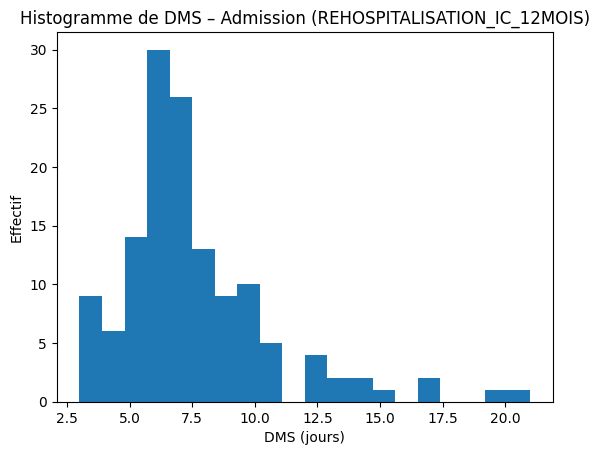

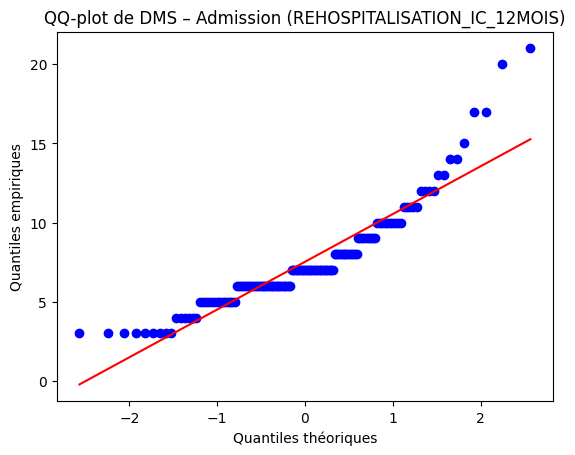

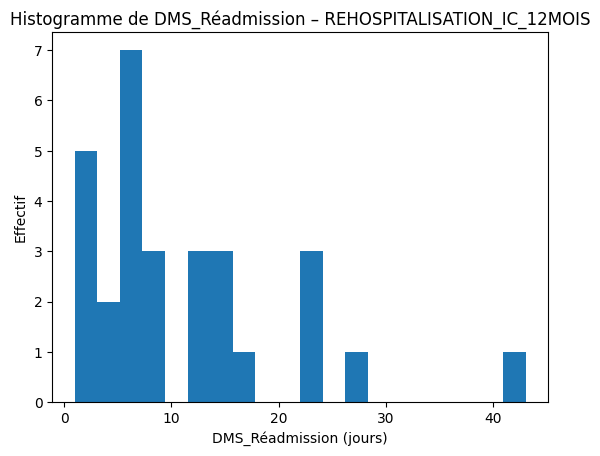

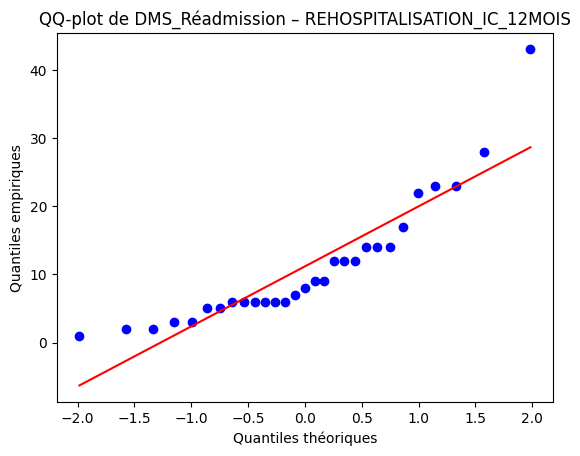

In [94]:
# Remplacez par l’horizon que vous voulez examiner
horizon = 'REHOSPITALISATION_IC_12MOIS'
levels  = ['SAU & transfert MCO', 'admission directe']

# Séries Admission vs Réadmission
x_adm  = df_clean.loc[df_clean['MODE_ADMISSION'].isin(levels), 'DMS'].dropna()
x_read = df_clean.loc[
    (df_clean[horizon] == 'Yes') & 
    df_clean['MODE_READMISSION_IC'].isin(levels),
    'DMS_REHOSPITALISATION'
].dropna()

# 1) Histogramme Admission
plt.hist(x_adm, bins=20)
plt.title(f'Histogramme de DMS – Admission ({horizon})')
plt.xlabel('DMS (jours)')
plt.ylabel('Effectif')
plt.show()

# 2) QQ-plot Admission
stats.probplot(x_adm, dist='norm', plot=plt)
plt.title(f'QQ-plot de DMS – Admission ({horizon})')
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles empiriques')
plt.show()

# 3) Histogramme Réadmission
plt.hist(x_read, bins=20)
plt.title(f'Histogramme de DMS_Réadmission – {horizon}')
plt.xlabel('DMS_Réadmission (jours)')
plt.ylabel('Effectif')
plt.show()

# 4) QQ-plot Réadmission
stats.probplot(x_read, dist='norm', plot=plt)
plt.title(f'QQ-plot de DMS_Réadmission – {horizon}')
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles empiriques')
plt.show()